# Introduction
In this notebook i'll be using the [Twitch API](https://dev.twitch.tv/docs/api) to collect some real time information about the top streams, and then making a simple data analysis.

I'll try to summarize the whole process of getting the API ready, requests, etc, but i encourage you to read the official documentation in order to fully understand it.

I hope you like it and let me now what can i improve.

# Imports
Importing all the packages needed for this project.

In [1]:
#Imports
#Api requests
import requests
from IPython.display import JSON
import json
#Data Manipulation
import pandas as pd
from collections import defaultdict
from datetime import datetime as dt, timezone, timedelta
#Data Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Setting the API
# Getting Client ID and Secret
The first thing you should do is Register an Application on Twitch (More info: [Register an Application](https://dev.twitch.tv/docs/api#step-1-register-an-application)).

When you finished that, you'll end up with 2 important keys you'll be using a lot:
* Client ID
* Secret

It's worth noting this from Twitch API documentation: 
> IMPORTANT Treat client secrets as you would your password. You must keep it confidential and never expose it to users, even in an obscured form.

That's why i'm going to hide both keys now, but you ensure you store your own Client ID and Secret in your code.

In [2]:
#Client ID
client_id = "Your-Client-ID-here"
#Secret
secret = "Your-Secret-here"

# Access Tokens
Basically, Twitch use Access Tokens to let us access resources. There are 2 access tokens:
* App Access Tokens: Tokens that does not require user's permission.
* User Access Tokens: Tokens that DOES require user's permission.

We'll be using an **App Access Token** because we only need some basic data. More info: ([Authentication](https://dev.twitch.tv/docs/authentication)).

# Getting an App Access Token
To get the token, we need to send an HTTP POST request to https://id.twitch.tv/oauth2/token with a few parameters:
* **client_id**: Your Client ID
* **client_secret**: Your Secret
* **grant_type** : Must be set to "*client_credentials*"

If the request succeeds, it returns an access token, with its type and expire time. More info: ([Client credentials grant flow](https://dev.twitch.tv/docs/authentication/getting-tokens-oauth/#client-credentials-grant-flow))

In [4]:
#Request app access token
url = 'https://id.twitch.tv/oauth2/token'
body = 'client_id={0}&client_secret={1}&grant_type={2}'.format(client_id, secret, "client_credentials")

result = requests.post(url, data = body)

#Explore result
JSON(result.text)

/opt/conda/lib/python3.7/site-packages/IPython/core/display.py:911: UserWarning: JSON expects JSONable dict or list, not JSON strings
  warnings.warn("JSON expects JSONable dict or list, not JSON strings")


<IPython.core.display.JSON object>

In [5]:
#Transform the result into json and get the app access token and token type
app_access_token = json.loads(result.text)["access_token"]
token_type = json.loads(result.text)["token_type"].capitalize()

# Methods
With our token ready we can now start coding, but first, let's define some methods:
* **get_url** : Builds an url with multiple parameters of different types, like: "url.com?param1=value1&param2=value2"
* **get_url_one_param** : Builds an url with multiple parameters of same type, like: "url.com?param1=value1&param1=value2"
* **get_top_streams** : Request n top streams and return the data in a dictionary
* **chunk_list** : Chunk a list into sublists of a given size

In [6]:
def get_url(url, param_dict):
    """
    Method that builds an url request with multiple parameters of different types

    Args:
        url (str): The base url string before the "?"
        param_dict (dict): A dictionary with the name of the parameters and its values

    Returns:
        url (str): The modified url with parameters added
    """
    #Initialize the query
    url += "?"
    #Loop through the parameters in the dictionary
    for idx, key in enumerate(param_dict.keys()):
        #Only add & at start
        if idx != 0: url += "&"
        #Stack the parameters
        url += "{0}={1}".format(key, param_dict[key])
    #Return the whole url with its parameters
    return url

In [7]:
def get_url_one_param(url, param_name, param_values):
    """
    Method that builds an url request with multiple parameters of the same type

    Args:
        url (str): The base url string before the "?"
        param_name (str): The name of the parameter
        param_values (list) : A list with the parameter values

    Returns:
        url (str): The modified url with parameters added
    """
    #Initialize the query
    url += "?"
    #Loop through parameter values
    for idx, value in enumerate(param_values):
        #Add & between params
        if idx != 0: url += "&"
        #Stack the parameters
        url += param_name + "=" + value
    #Return the whole url with its parameters
    return url

In [8]:
def get_top_streams(url, n, fields, chunk_size=100):
    """
    Method that request n top streams from the api

    Args:
        url (str): The base url string before the "?"
        n (int) : Quantity of top streams to request
        fields (list): A list of stream fields of interest
        chunk_size (int) : Default=100. The maximum chunk size to request.

    Returns:
        streams_dict (dict): The requested top n streams stored in a dictionary, ready to
            be transformed into a DataFrame.
    """
    #Set the parameters
    params = {"first" : chunk_size}
    pagination = ""
    #Initialize empty dictionary
    streams_dict = defaultdict(list)
    #Iterate through each chunk
    for chunk in range(0, n, chunk_size):
        #If is not the first iteration
        if chunk > 0:
            #Set the after parameter
            params["after"] = pagination
        #Get final url
        final_url = get_url(url, params)
        #Request streams equal to chunk_size
        result = requests.get(final_url, headers = header_token_client_id)
        #Add the data to the streams dictionary
        #(Keys will be column names, and values will be the actual columns)
        for stream in json.loads(result.text)["data"]:
            for key, value in stream.items():
                if key in fields:
                    streams_dict[key].append(value)
        #Save the cursor value
        pagination = json.loads(result.text)["pagination"]["cursor"]
    #Return the dictionary
    return streams_dict

In [9]:
def chunk_list(p_list, chunk_size=100):
    """
    Method that chunks a list in several parts of a given size

    Args:
        p_list (list): The list to chunk
        chunk_size (int) : Default=100. The maximum size of the final list chunks

    Returns:
        final_list (list): A list storing chunks of the original list.
    """
    #Initialize final list
    final_list = []
    #Iterate through chunks
    for chunk in range(0, len(p_list), chunk_size):
        final_list.append(p_list[chunk : chunk+chunk_size])
    #Return the lists
    return final_list

# Top 5000 streams
Let's get basic data from the most viewed 5000 streams right now using the [Get Streams](https://dev.twitch.tv/docs/api/reference#get-streams) request, and then store it in a DataFrame.

In [10]:
#Header with app access token authorization AND client id
header_token_client_id = {'Authorization' :  "%s %s" % (token_type, app_access_token),
        "Client-Id" : client_id}
#Get the top 5000 streams and save it in a dataframe
stream_fields = ['user_id', 'user_login', 'user_name', 'game_name', 'title',
       'viewer_count', 'started_at', 'language', 'tag_ids', 'is_mature']
streams_df = pd.DataFrame(get_top_streams("https://api.twitch.tv/helix/streams", 5000, stream_fields))
#See results
streams_df.head()

,user_id,user_login,user_name,game_name,title,viewer_count,started_at,language,tag_ids,is_mature
0,26261471,asmongold,Asmongold,Special Events,THE OTK GAMES EXPO - !vote - Powered by Razer ...,115108,2022-06-08T18:00:02Z,en,[6ea6bca4-4712-4ab9-a906-e3336a9d8039],False
1,238813810,eliasn97,eliasn97,Just Chatting,BRUCH WATCHPARTY + Reactions 🔥 | !eligella,54943,2022-06-08T19:00:22Z,de,[9166ad14-41f1-4b04-a3b8-c8eb838c6be6],False
2,72550899,roshtein,ROSHTEIN,Slots,🔞 MAX WIN ON !BOWERY | CHECK MY !SOCIALS ITS P...,42050,2022-06-08T12:31:42Z,en,"[6ea6bca4-4712-4ab9-a906-e3336a9d8039, 2574c04...",True
3,37402112,shroud,shroud,Special Events,OTK Games Expo!!!,37991,2022-06-08T17:34:11Z,en,[6ea6bca4-4712-4ab9-a906-e3336a9d8039],False
4,207813352,hasanabi,HasanAbi,Just Chatting,WENT ON THE BBC -NEW SCOTUS,31194,2022-06-08T17:59:18Z,en,"[cea7bc0c-75a5-4446-8743-6db031b71550, d4461e9...",False


# Aditional User data

Now that we have the *User Ids*, we can **extract some aditional data** using the [Get Users](https://dev.twitch.tv/docs/api/reference#get-users) request, and passing it the 5000 User Ids in the url as *parameters*. In this case, we are going to extract "id", "broadcaster_type", "view_count" and "created_at" fields.

In [11]:
#Get additional info of those 5000 users

#Initialize user_info dictionary
user_info = defaultdict(list)
#Request by chunks (100 users per request max)
for user_ids in chunk_list(streams_df.user_id.values):
    #Set url for those 100 users and request
    url = get_url_one_param("https://api.twitch.tv/helix/users", "id", user_ids)
    result = requests.get(url, headers = header_token_client_id)
    #Save those 100 users in the dictionary with its user ids
    for user in json.loads(result.text)["data"]:
        for key, value in user.items():
            if key in ["id", "broadcaster_type", "view_count", "created_at"]:
                user_info[key].append(value)

Now we can *transform* this aditional data to a DataFrame, and *merge* it with the streams DataFrame.

In [12]:
#Merge this columns to the streams dataframe
users_df = pd.DataFrame(user_info)
users_df.columns = ["user_id", "user_broadcaster_type", "user_total_viewer_count", "user_created_at"]
streams_df = streams_df.merge(users_df, how="left", on="user_id")
#See results
streams_df.head()

,user_id,user_login,user_name,game_name,title,viewer_count,started_at,language,tag_ids,is_mature,user_broadcaster_type,user_total_viewer_count,user_created_at
0,26261471,asmongold,Asmongold,Special Events,THE OTK GAMES EXPO - !vote - Powered by Razer ...,115108,2022-06-08T18:00:02Z,en,[6ea6bca4-4712-4ab9-a906-e3336a9d8039],False,partner,236178673,2011-11-20T10:39:27Z
1,238813810,eliasn97,eliasn97,Just Chatting,BRUCH WATCHPARTY + Reactions 🔥 | !eligella,54943,2022-06-08T19:00:22Z,de,[9166ad14-41f1-4b04-a3b8-c8eb838c6be6],False,partner,23276036,2018-07-15T12:43:44Z
2,72550899,roshtein,ROSHTEIN,Slots,🔞 MAX WIN ON !BOWERY | CHECK MY !SOCIALS ITS P...,42050,2022-06-08T12:31:42Z,en,"[6ea6bca4-4712-4ab9-a906-e3336a9d8039, 2574c04...",True,,94748379,2014-10-06T10:15:37Z
3,37402112,shroud,shroud,Special Events,OTK Games Expo!!!,37991,2022-06-08T17:34:11Z,en,[6ea6bca4-4712-4ab9-a906-e3336a9d8039],False,partner,570770965,2012-11-03T15:50:32Z
4,207813352,hasanabi,HasanAbi,Just Chatting,WENT ON THE BBC -NEW SCOTUS,31194,2022-06-08T17:59:18Z,en,"[cea7bc0c-75a5-4446-8743-6db031b71550, d4461e9...",False,partner,113564733,2018-03-23T20:06:49Z


# Preprocessing

Let's set the *correct type* to the date columns, and use them to calculate **hours on live** for each stream.

In [13]:
#Transform the date columns
streams_df.started_at = pd.to_datetime(streams_df.started_at)
streams_df.user_created_at = pd.to_datetime(streams_df.user_created_at)
#Add hours on live column
streams_df["hours_on_live"] = (dt.now(timezone.utc) - streams_df.started_at) / timedelta(hours=1)
#See results
streams_df.head()

,user_id,user_login,user_name,game_name,title,viewer_count,started_at,language,tag_ids,is_mature,user_broadcaster_type,user_total_viewer_count,user_created_at,hours_on_live
0,26261471,asmongold,Asmongold,Special Events,THE OTK GAMES EXPO - !vote - Powered by Razer ...,115108,2022-06-08 18:00:02+00:00,en,[6ea6bca4-4712-4ab9-a906-e3336a9d8039],False,partner,236178673,2011-11-20 10:39:27+00:00,3.943387
1,238813810,eliasn97,eliasn97,Just Chatting,BRUCH WATCHPARTY + Reactions 🔥 | !eligella,54943,2022-06-08 19:00:22+00:00,de,[9166ad14-41f1-4b04-a3b8-c8eb838c6be6],False,partner,23276036,2018-07-15 12:43:44+00:00,2.937831
2,72550899,roshtein,ROSHTEIN,Slots,🔞 MAX WIN ON !BOWERY | CHECK MY !SOCIALS ITS P...,42050,2022-06-08 12:31:42+00:00,en,"[6ea6bca4-4712-4ab9-a906-e3336a9d8039, 2574c04...",True,,94748379,2014-10-06 10:15:37+00:00,9.415609
3,37402112,shroud,shroud,Special Events,OTK Games Expo!!!,37991,2022-06-08 17:34:11+00:00,en,[6ea6bca4-4712-4ab9-a906-e3336a9d8039],False,partner,570770965,2012-11-03 15:50:32+00:00,4.374220
4,207813352,hasanabi,HasanAbi,Just Chatting,WENT ON THE BBC -NEW SCOTUS,31194,2022-06-08 17:59:18+00:00,en,"[cea7bc0c-75a5-4446-8743-6db031b71550, d4461e9...",False,partner,113564733,2018-03-23 20:06:49+00:00,3.955609


# Tags

In order to group by tags, we need to *explode* the column in a different DataFrame, then we get the *unique tags* used on these 5000 streams.

In [14]:
#Explode the tag_ids column
streams_df_tag_exp = streams_df.explode("tag_ids")
#Save top 100 tag ids
unique_tag_ids = list(streams_df_tag_exp.groupby("tag_ids", as_index=False).size()\
                     .sort_values("size", ascending=False)["tag_ids"].values)
#See results
len(unique_tag_ids)

520

Now we need to convert those Tag IDs into Tag Names. In order to do that we are going to **request** to the API for Tags Data, passing it these 520 Tag Ids in the url as parameters, using the [Get All Stream Tags](https://dev.twitch.tv/docs/api/reference#get-all-stream-tags) request.

In [15]:
#Get all tags from twitch

#Initialize tag dictionary
#{tag id : tag English name}
tags_dict = {}
#Request by chunks (100 tags per request max)
for tags in chunk_list(unique_tag_ids):
    #Set url for those 100 tags and request
    url = get_url_one_param("https://api.twitch.tv/helix/tags/streams", "tag_id", tags)
    result = requests.get(url, headers = header_token_client_id)
    #Save those 100 tag names in the list with its tag ids
    for tag in json.loads(result.text)["data"]:
        #Save only tags added manually by the streamers (avoiding language tags)
        if tag["is_auto"] == False:
            tag_id = tag["tag_id"]
            tag_name = tag["localization_names"]["en-us"]
            tags_dict[tag_id] = tag_name

Note that we **filter** the tags where the field "is_auto" is False, that is because the tags automatically added by Twitch are more often language tags and we already have a language column.

Said that, we can use the dictionary we created to **map** the *tag_ids* columns into a new *tag_name* column.

Finally we can safely **drop** rows with NaN values on *tag_name* column because they correspond to tags automatically added by Twitch, and we are not interested in those.

In [16]:
#Add the information to the dataframe
streams_df_tag_exp["tag_name"] = streams_df_tag_exp["tag_ids"].map(tags_dict)
#Drop rows with "tag_name" NaN values (tags added automatically by Twitch)
streams_df_tag_exp.dropna(subset=["tag_name"], inplace=True)
#See results
streams_df_tag_exp[["tag_ids", "tag_name"]]

,tag_ids,tag_name
2,2574c042-42d3-4768-9067-e6b415aef9c3,Sweden
2,377a27f0-e3a6-4a02-99a2-8eca81163ca7,Germany
2,41999c17-eb6c-4231-93b3-2d9df3513cb0,Turkey
4,cea7bc0c-75a5-4446-8743-6db031b71550,Educational
4,d4461e94-570b-4973-b6a1-3afe026c12ca,Social Eating
...,...,...
4984,e027fb8b-219e-4959-8240-a4a082be0316,Retro
4984,52d7e4cc-633d-46f5-818c-bb59102d9549,Vtuber
4984,bd6fc011-575a-43f0-8418-9f912a295362,Reading Aloud
4984,6606e54c-f92d-40f6-8257-74977889ccdd,Anime


# Visualization
With our data ready, we can explore it and visualize it. 

It's worth noting that these plots may look different on your notebooks because the streams on live will differ from the ones now as i typing this.

# Top 20 Most viewed Streamers

Let's see the **Top 20 most viewed Streamers** right now.

Text(0.5, 1.0, 'Top 20 Streamers')

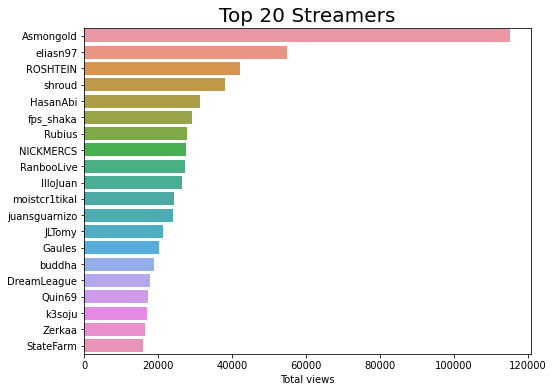

In [17]:
#Top 20 by viewer count
streams_df.sort_values("viewer_count", ascending=False, inplace=True)
plt.rcParams["figure.figsize"] = (8,6)
ax = sns.barplot(x="viewer_count", y="user_name", data=streams_df[:20])
ax.set_ylabel("")
ax.set_xlabel("Total views")
ax.set_title("Top 20 Streamers", fontsize=20)

We can see **Asmongold** being the most viewed Streamer with almost 120k viewers!

Then it comes **eliasn97** with around 60k viewers, and the rest are pretty even varying from 40k to 15k.

# Mature content

Let's explore the **mature content** on these 5000 streams.

Text(0.5, 1.0, 'Mature content Streams')

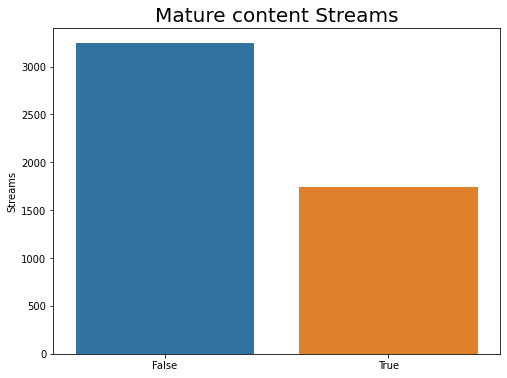

In [18]:
#Mature and not mature streams
plt.rcParams["figure.figsize"] = (8,6)
ax = sns.countplot(x="is_mature", data=streams_df)
ax.set_ylabel("Streams")
ax.set_xlabel("")
ax.set_title("Mature content Streams", fontsize=20)

It seems like *more than 1500 Streams* contains Mature content, that's almost **a third** of the dataset!

# Top Streams Languages
Let's count the stream languages.

Text(0.5, 1.0, 'Top 20 Streams Languages')

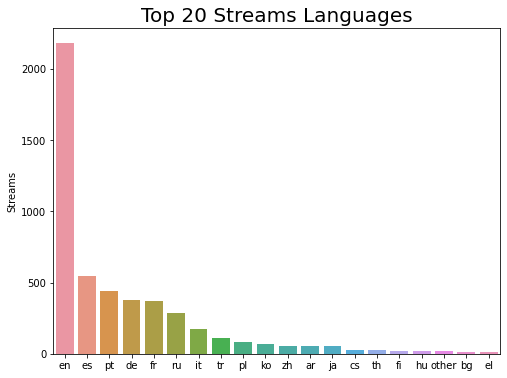

In [19]:
#Top Streams Languages
topLanguages = streams_df.groupby("language", as_index=False).size().sort_values("size", ascending=False)
plt.rcParams["figure.figsize"] = (8,6)
ax = sns.barplot(x="language", y="size", data=topLanguages[:20])
ax.set_ylabel("Streams")
ax.set_xlabel("")
ax.set_title("Top 20 Streams Languages", fontsize=20)

We can see an clear supremacy of the **English language** with more than 2000 Streams from the top 5000!

Far away, it comes **Spanish**, **Portuguese** and **German** with approx 500-400 Streams.

# Top Games played

Let's visualize one of the most important metrics of this dataset: **Which are the most played games right now?**

Text(0.5, 1.0, 'Top 20 Games played')

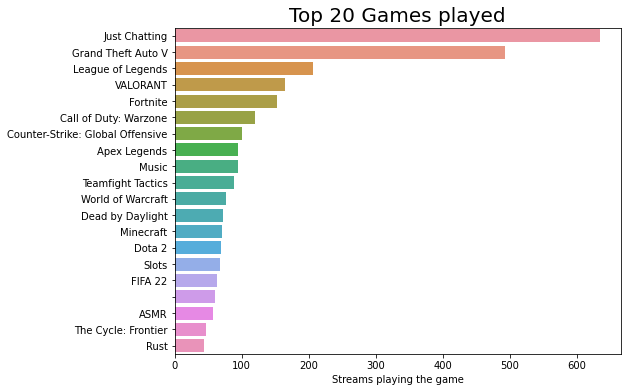

In [20]:
#Top Games played
topGames = streams_df.groupby("game_name", as_index=False).size().sort_values("size", ascending=False)
plt.rcParams["figure.figsize"] = (8,6)
ax = sns.barplot(y="game_name", x="size", data=topGames[:20])
ax.set_xlabel("Streams playing the game")
ax.set_ylabel("")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set_title("Top 20 Games played", fontsize=20)

* The most played game is **Just Chatting** which in fact is not a game, rather a category for those streams where the streamer talk with the viewers. More than 600 Streamers are Just Chatting. It seems like most streamers choose this way of streaming over playing a game.

* Almost 500 Streamers are playing **GTA V**, quite popular.

* Then it comes **LoL**, **Valorant**, **Fortnite** and other games with around 200 Streamers.

# Tags

Now let's use or exploded DataFrame "streams_df_tag_exp" to visualize the **Top 20 Tags** (manually added).

Text(0.5, 1.0, 'Top 20 Tags')

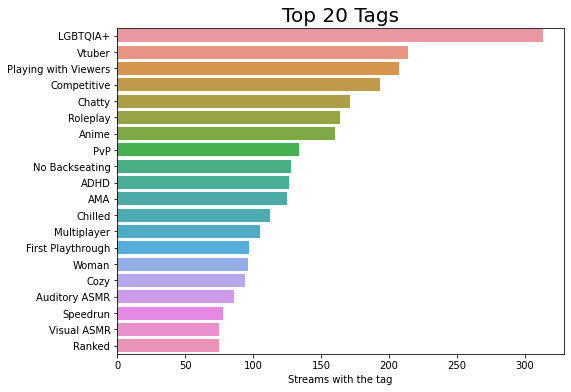

In [21]:
#Top Tags
topTags = streams_df_tag_exp.groupby("tag_name", as_index=False).size().sort_values("size", ascending=False)
plt.rcParams["figure.figsize"] = (8,6)
ax = sns.barplot(y="tag_name", x="size", data=topTags[:20])
ax.set_xlabel("Streams with the tag")
ax.set_ylabel("")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.set_title("Top 20 Tags", fontsize=20)

We can see an interesting **LGBTQIA+ Tag** with more than 300 Streams using it!

# Relation between features

Let's look for correlation in some features, drawing **regplots** and **scatterplots**.

Text(0.5, 1.0, 'Actual stream Viewer count vs user total viewer count')

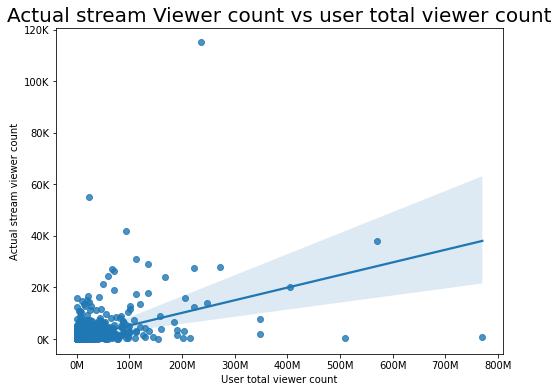

In [22]:
#Actual stream Viewer count vs user total viewer count
plt.rcParams["figure.figsize"] = (8,6)
ax = sns.regplot(x="user_total_viewer_count", y="viewer_count", data=streams_df)
ax.set_xlabel("User total viewer count")
ax.set_ylabel("Actual stream viewer count")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))
ax.set_title("Actual stream Viewer count vs user total viewer count", fontsize=20)

It seems like Streamers with more total viewers **tend to have more viewers** in his Streams, which make sense since they are more popular.

Text(0.5, 1.0, 'Actual stream Viewer count by hours on live')

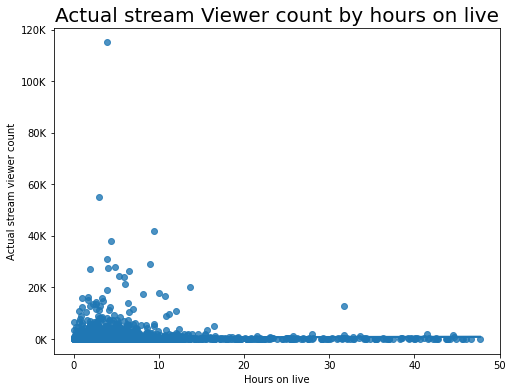

In [23]:
#Actual stream Viewer count by hours on live
plt.rcParams["figure.figsize"] = (8,6)
ax = sns.regplot(x="hours_on_live", y="viewer_count", data=streams_df)
ax.set_xlabel("Hours on live")
ax.set_ylabel("Actual stream viewer count")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
ax.set_title("Actual stream Viewer count by hours on live", fontsize=20)

We can't see a correlation because there are many streams with less than 5K viewers.

But what we can see is that Streams with **less hours on live** are the ones that have the **most viewers**.

This is natural due to the viewers wanting to consume **new content**.

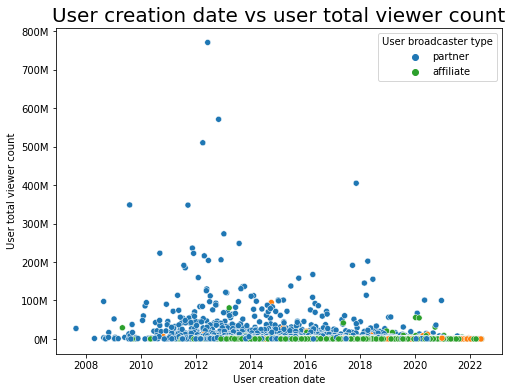

In [24]:
#User creation date vs user total viewer count
plt.rcParams["figure.figsize"] = (8,6)
ax = sns.scatterplot(x="user_created_at", y="user_total_viewer_count",
                     hue="user_broadcaster_type", data=streams_df)
ax.set_xlabel("User creation date")
ax.set_ylabel("User total viewer count")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000000) + 'M'))
ax.set_title("User creation date vs user total viewer count", fontsize=20)
ax.legend(title="User broadcaster type")

There is not a clear correlation between **User creation date** and **User total viewer count**.

But we can see almost all the Streamers with the "**Affiliate**" broadcaster type have less than 50M total views.

This makes total sense, since once the Streamers achieve getting the **Partner**, they have more tools and incomes to keep growing.

# Stream titles

Finally, we can build a simple **wordcloud** to visualize the **most common words on Stream titles**.

I choose to exclude social media words because there were too many, but you can customize the **stopwords** as you want.

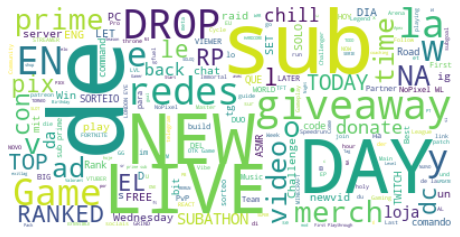

In [25]:
#Concatenate all stream titles
all_titles = " ".join(title for title in streams_df.title)
#Create stopwords list:
stopwords = set(STOPWORDS)
stopwords.update(["discord", "yt", "youtube", "twitter", "stream", "social", "instagram",
                  "insta", "tiktok", "socials"])
#Generate a word cloud from stream titles
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(all_titles)
#Show the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()